**1a)**
Implement a function that computes the binary entropy

The function takes as input one feature vector x and the corresponding label y. Binary entropy means binary labels y=0/1

**1b)**
Implement a function that takes one given feature of a dataset, and finds the best split (the split that
minimises the entropy) for the data. It is common to iterate over the data feature values, and calculate
the entropy for the subsets that are larger or smaller (or equal) than the current value in the iteration.
return the split that minimises the entropy and the corresponding entropy for the split

**1c)**
Implement a function that takes a dataset (nsamples × nfeatures) and finds the single best split (the split
with the least entropy) across all features. That is the function find_best_split. Return the best split
found.

**1d)**
Using the functions you implemented above, write your own version of the Classification Tree algorithm,
using recursion. Remember to include a parameter specifying the maximum depth of the tree to prevent
overfitting
![Ethem univariate tree construction](img/decision_tree.png)

In [47]:
MINIMUM_ENTROPY = 0.01
MINIMUM_PURITY = 1e-15
MAXIMUM_DEPTH = 50

import numpy as np
from numpy import log2
import pandas as pd
import matplotlib.pyplot as plt
import sys

def entropy(y: np.array):
    counts = np.bincount(y)
    p_0 = counts[0] / len(y)
    p_1 = 1 - p_0
    log2p0 = 0 if p_0 == 0 else log2(p_0)
    log2p1 = 0 if p_1 == 0 else log2(p_1)
    return -p_0 * log2p0 - p_1 * log2p1


def split_feature(x: np.array, y: np.array):
    min_impurity_index = None
    min_impurity = sys.float_info.max
    # Iterate over all values in the features in x.
    i_sorted = np.argsort(x)
    x = x[i_sorted]
    y = y[i_sorted]

    for i in range(len(x)-1):
        sub_1 = y[:i+1]
        sub_2 = y[i+1:]
        e_1 = entropy(sub_1)
        e_2 = entropy(sub_2)
        impurity = e_1 * len(sub_1) / len(x) + e_2 * len(sub_2) / len(x)
        if impurity < min_impurity:
            min_impurity = impurity
            min_impurity_index = i

    split_value = (x[min_impurity_index+1] + x[min_impurity_index])/2
    return split_value, min_impurity

def find_best_split(X: np.array, y: np.array):
    M = X.shape[1]
    min_impurity_global = sys.float_info.max
    min_impurity_feature_index = None
    split_value = None
    for i in range(M):
        feature = X[:, i]
        value, min_impurity = split_feature(feature, y)
        if min_impurity < min_impurity_global:
            min_impurity_global = min_impurity
            min_impurity_feature_index = i
            split_value = value
            # We break out if we find 0 impurity
            if min_impurity_global < MINIMUM_PURITY:
                break

    return min_impurity_feature_index, split_value, min_impurity_global


class Tree:
    # Initialize variables
    def __init__(self, level, left):
        self.__split_value = None
        self.__feature_index = None
        self.__left_child = None
        self.__right_child = None
        self.__value = None
        self.__level = level + 1
        if left is None:
            self.__direction = "Root"
        else:
            self.__direction = "Left" if left else "Right"

    # Implements the "GenerateTree"-function from Fig. 9.3 in the book.
    def fit(self, data, labels):

        self.__value = 1 if np.mean(labels) > 0.5 else 0
        if entropy(labels) < MINIMUM_ENTROPY:  # Stopping condition for recursion
            # Pick the label that has the majority. To be used if we are a leaf-node
            print(self.__direction,"leaf node at level",self.__level, "with value", self.__value)
            return

        if self.__level >= MAXIMUM_DEPTH:
            print("Max depth reached, bailing out")
            return

        feature_index, split_value, purity = find_best_split(data, labels)
        #        if purity < MINIMUM_PURITY:
        #            print("0 or close to 0 in impurity, this should be a leaf!")
        #            return

        self.__feature_index = feature_index
        self.__split_value = split_value
        print(self.__direction,"node at level", self.__level, ". Feature index:", feature_index, ", split value",split_value)

        feature = data[:, feature_index]
        indexes_left = np.where(feature <= split_value)[0]
        indexes_right = np.where(feature > split_value)[0]
        if len(indexes_right) == 0 or len(indexes_right) == 0 :
            print("Not able to split data, we consider this a leaf node")
            return

        # Create branches
        self.__left_child = Tree(self.__level, True)
        self.__right_child = Tree(self.__level, False)
        # Generate sub-trees.
        self.__left_child.fit(data[indexes_left, :], labels[indexes_left])
        self.__right_child.fit(data[indexes_right, :], labels[indexes_right])

    # Find leaf corresponding to row
    def __predict(self, x):
        if self.__left_child is None and self.__right_child is None:  # We are a leaf-node
            return self.__value

        feature_val = x[self.__feature_index]
        if feature_val <= self.__split_value:
            return self.__left_child.__predict(x)
        else:
            return self.__right_child.__predict(x)

    def predict(self, X):
        N = X.shape[0]
        y = np.empty(N)
        for i in range(N):
            y[i] = self.__predict(X[i, :])
        return y

data = pd.read_csv("data/tictac-end.csv", skiprows=7, delimiter=" ")


y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

random_indexes = np.random.permutation(y.shape[0])
y = y[random_indexes]
X = X[random_indexes]
#y = y[:150]
#X = X[:150,:]

#print(y)
#print(X)

decision_tree = Tree(0,None)
decision_tree.fit(X, y)


Root node at level 1 . Feature index: 4 , split value 0.0
Left node at level 2 . Feature index: 4 , split value -1.0
Left node at level 3 . Feature index: 6 , split value 0.0
Left node at level 4 . Feature index: 2 , split value 0.5
Left leaf node at level 5 with value 0
Right node at level 5 . Feature index: 6 , split value 0.0
Not able to split data, we consider this a leaf node
Right node at level 4 . Feature index: 0 , split value 0.0
Left node at level 5 . Feature index: 8 , split value 0.5
Left leaf node at level 6 with value 0
Right node at level 6 . Feature index: 7 , split value 0.0
Left node at level 7 . Feature index: 3 , split value 0.0
Left node at level 8 . Feature index: 5 , split value 1.0
Not able to split data, we consider this a leaf node
Right leaf node at level 8 with value 0
Right leaf node at level 7 with value 1
Right node at level 5 . Feature index: 3 , split value 0.0
Left node at level 6 . Feature index: 3 , split value 0.0
Not able to split data, we consider

**1e)**
Test your implementation on the datasets in blobs.csv and flame.csv. Plot the data, and the regions
found by the tree.

First, test with blobs.csv


Root node at level 1 . Feature index: 0 , split value 0.51615
Left node at level 2 . Feature index: 1 , split value 0.44405
Left leaf node at level 3 with value 0
Right node at level 3 . Feature index: 1 , split value 0.9199999999999999
0 or close to 0 in impurity, this should be a leaf!
Right leaf node at level 4 with value 1
Right node at level 2 . Feature index: 1 , split value 0.28875
0 or close to 0 in impurity, this should be a leaf!
Right leaf node at level 3 with value 1


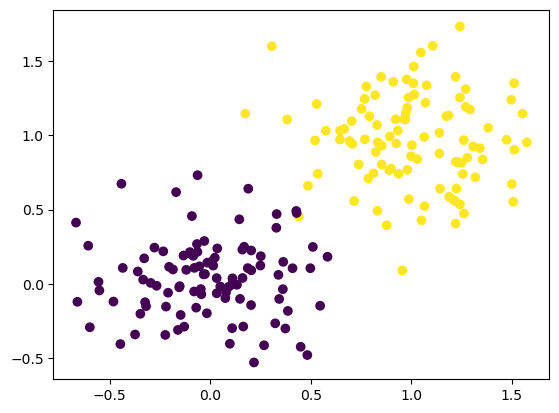

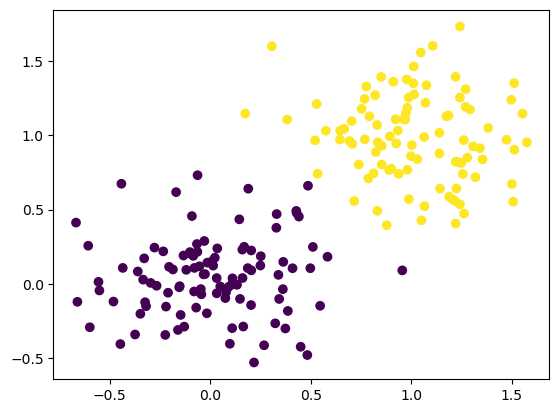

In [19]:
data = pd.read_csv("data/blobs.csv", skiprows=1, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

decision_tree = Tree(0,None)
decision_tree.fit(X, y)

# Plot the ground truth
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Now run predict on the whole training set and plot it similarly
y_pred = decision_tree.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)


Now, test on flame.csv

Root node at level 1 . Feature index: 1 , split value 20.475
Left leaf node at level 2 with value 1
Right node at level 2 . Feature index: 0 , split value 10.7
Left node at level 3 . Feature index: 0 , split value 3.35
0 or close to 0 in impurity, this should be a leaf!
Right node at level 4 . Feature index: 1 , split value 21.15
0 or close to 0 in impurity, this should be a leaf!
Right leaf node at level 5 with value 0
Right leaf node at level 3 with value 1


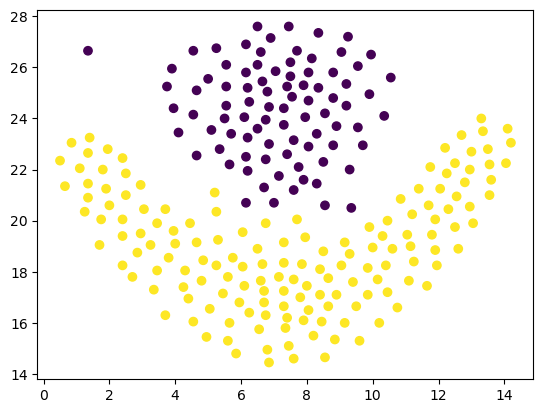

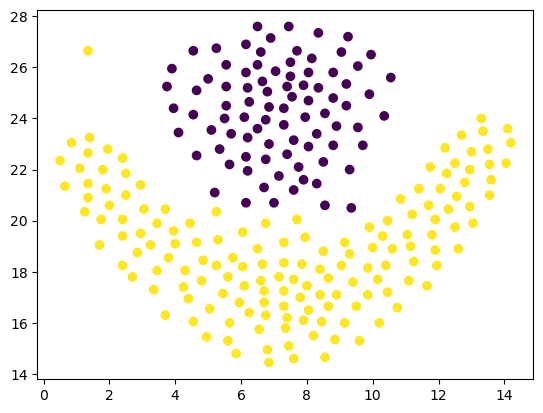

In [20]:
data = pd.read_csv("data/flame.csv", skiprows=5, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

decision_tree = Tree(0,None)
decision_tree.fit(X, y)

# Plot the ground truth
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Now run predict on the whole training set and plot it similarly
y_pred = decision_tree.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)



**1f)** Vizualise tree 
https://levelup.gitconnected.com/binary-tree-implementation-and-visualization-in-python-2f4782887ca2

**1g)** Test on tictac.csv
Split the data into training- and test-sets. Train your classification tree using the training set, and test it
using the testing set. How is the generalization performance?

In [60]:
data = pd.read_csv("data/tictac-end.csv", skiprows=7, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()
N = y.shape[0]
random_indexes = np.random.permutation(N)
y = y[random_indexes]
X = X[random_indexes]

N_train = int(N*0.8)

y_train = y[:N_train]
X_train = X[:N_train]

y_test = y[N_train:]
X_test = X[N_train:]

decision_tree = Tree(0,None)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

idx_true = y_pred[y_pred == y_test]
idx_false = y_pred[y_pred != y_test]
print (len(idx_true), len(idx_false))
accuracy = np.mean(y_pred == y_test)
print("Accuracy: ", accuracy)

# The accuracy is not very good at all compared to a logistic regression (as we did in lab 2)

Root node at level 1 . Feature index: 4 , split value -1.0
Left node at level 2 . Feature index: 7 , split value -1.0
Left node at level 3 . Feature index: 1 , split value -0.5
Left leaf node at level 4 with value 0
Right node at level 4 . Feature index: 0 , split value -1.0
Left node at level 5 . Feature index: 5 , split value 1.0
Not able to split data, we consider this a leaf node
Right node at level 5 . Feature index: 0 , split value 1.0
Not able to split data, we consider this a leaf node
Right node at level 3 . Feature index: 8 , split value 1.0
Not able to split data, we consider this a leaf node
Right node at level 2 . Feature index: 2 , split value 0.0
Left node at level 3 . Feature index: 2 , split value -1.0
Left node at level 4 . Feature index: 8 , split value -1.0
Left node at level 5 . Feature index: 5 , split value -0.5
Left leaf node at level 6 with value 0
Right node at level 6 . Feature index: 1 , split value -1.0
Left node at level 7 . Feature index: 7 , split value 